In [12]:
# importing libraries

import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import numpy as np

Some data sets have unequal length series. Two data sets with this characteristic are shipped with sktime: PLAID (univariate) and JapaneseVowels (multivariate). We cannot store unequal length series in numpy arrays. Instead, we use a nested pandas.DataFrame, where each cell is a pandas.Series. This is the default return type for all single problem loaders.

In [25]:
# general parameters

len_series = 100  # the leght max of the time series

In [26]:
# Create Nasa Dataframe

#import dataset
list_cells= ['B0005','B0006','B0007','B0018','B0025','B0026','B0027','B0028']
nasa_dataset={}
for cell in list_cells:
    cell_dataset = scipy.io.loadmat('/home/apetrella/Workspace/battery_tsc/dataset/Nasa/5. Battery Data Set/DS/'+ cell +'.mat', simplify_cells=True)
    del cell_dataset["__header__"]
    del cell_dataset["__version__"]
    del cell_dataset["__globals__"]
    
    nasa_dataset[cell] = cell_dataset[cell]


# divide the dataset in 3 parts: charge, discharge and impedance
# in this work, we used only the charge part
 
nasa_dict={}

# for each cell
for cell in list_cells:
    nasa_dict[cell]={}
    nasa_dict[cell]['charge'] = []
    nasa_dict[cell]['discharge'] = []
    nasa_dict[cell]['impedance'] = []

    # save into the right part of dict
    for key in range(len(nasa_dataset[cell]['cycle'])):
        if (nasa_dataset[cell]['cycle'][key]['type'] == 'charge' and key > 1 ):   # non cago il primo di ogni cella che vaneggia...
            nasa_dict[cell]['charge'].append(nasa_dataset[cell]['cycle'][key]['data'])

        if (nasa_dataset[cell]['cycle'][key]['type'] == 'discharge' ):
            nasa_dict[cell]['discharge'].append(nasa_dataset[cell]['cycle'][key]['data'])
        
        if (nasa_dataset[cell]['cycle'][key]['type'] == 'impedance' ):
            nasa_dict[cell]['impedance'].append(nasa_dataset[cell]['cycle'][key]['data'])

    
    # to calculate the SoH, we need to know the capacity. we save the capacity information from discharge to charge
    for k,v in enumerate(nasa_dict[cell]['charge']):
        
        if (k < len(nasa_dict[cell]['discharge'])):
            nasa_dict[cell]['charge'][k]['SoH'] = nasa_dict[cell]['discharge'][k]['Capacity']
        else:
            # per ora ricopio l'ultimo letto
            nasa_dict[cell]['charge'][k]['SoH'] = nasa_dict[cell]['charge'][k-1]['SoH']


    #from capacity to SoH
    # the first one is 100, and the other ones are calculated
    start_Ah= 0
    for k,v in enumerate(nasa_dict[cell]['charge']):
        if (k == 0):
            start_Ah = nasa_dict[cell]['charge'][k]['SoH'] 
            nasa_dict[cell]['charge'][k]['SoH'] = 100
        else:
            nasa_dict[cell]['charge'][k]['SoH'] = int(round(nasa_dict[cell]['charge'][k]['SoH'] / start_Ah * 100))


    #convert array in panda series, it is nedded to use sktime.



    serie_vuota = []
    #for i in range(len_series):
    #    serie_vuota.append(0.0)

    for k,v in enumerate(nasa_dict[cell]['charge']):
        nasa_dict[cell]['charge'][k]['Voltage_measured'] = pd.Series(nasa_dict[cell]['charge'][k]['Voltage_measured'][:len_series])
        #nasa_dict[cell]['charge'][k]['Voltage_measured'] = pd.Series(nasa_dict[cell]['charge'][k]['Voltage_measured'])
        #nasa_dict[cell]['charge'][k]['Current_measured'] = pd.Series(nasa_dict[cell]['charge'][k]['Current_measured'][:len_series])
        nasa_dict[cell]['charge'][k]['Temperature_measured'] = pd.Series(nasa_dict[cell]['charge'][k]['Temperature_measured'][:len_series])
        #nasa_dict[cell]['charge'][k]['Temperature_measured'] = pd.Series(nasa_dict[cell]['charge'][k]['Temperature_measured'])
        #nasa_dict[cell]['charge'][k]['q'] = pd.Series(serie_vuota)
        #nasa_dict[cell]['charge'][k]['Current_charge'] = pd.Series(nasa_dict[cell]['charge'][k]['Current_charge'][:len_series])
        #nasa_dict[cell]['charge'][k]['Voltage_charge'] = pd.Series(nasa_dict[cell]['charge'][k]['Voltage_charge'][:len_series])
        #nasa_dict[cell]['charge'][k]['Time'] = pd.Series(nasa_dict[cell]['charge'][k]['Time'][:len_series])

        



# unify, the dataset, as a unique battery/cell
nasa_dict_unify={}
nasa_dict_unify['charge'] = []
#nasa_dict_unify['discharge'] = []
#nasa_dict_unify['impedance'] = []

for cell in list_cells:
    # unisco charge
    for k,v in enumerate(nasa_dict[cell]['charge']):
        nasa_dict_unify['charge'].append(v)
    # unisco charge
    # for k,v in enumerate(nasa_dict[cell]['discharge']):
    #     nasa_dict_unify['discharge'].append(v)
    # # unisco charge
    # for k,v in enumerate(nasa_dict[cell]['impedance']):
    #     nasa_dict_unify['impedance'].append(v)

#print(nasa_dict_unify['charge'])

df_nasa= pd.DataFrame(nasa_dict_unify['charge'])

#rimuovo dati "non interessanti"(che non voglio usare)
df_nasa=df_nasa.drop("Current_charge",axis=1)
df_nasa=df_nasa.drop("Voltage_charge",axis=1)
df_nasa=df_nasa.drop("Time",axis=1)
#df_nasa=df_nasa.drop("q",axis=1)
df_nasa=df_nasa.drop("Current_measured",axis=1)

df_nasa

,Voltage_measured,Temperature_measured,SoH
0,0 3.325055 1 3.001951 2 3.434644 3...,0 29.341851 1 29.335723 2 29.33471...,100
1,0 3.352604 1 3.035879 2 3.459468 3...,0 29.553301 1 29.538751 2 29.53900...,99
2,0 3.378799 1 3.066145 2 3.485569 3...,0 29.456340 1 29.436998 2 29.43251...,99
3,0 3.372871 1 3.063766 2 3.478147 3...,0 29.481334 1 29.461955 2 29.46636...,99
4,0 3.366775 1 3.059322 2 3.471082 3...,0 29.395820 1 29.389419 2 29.38870...,99
...,...,...,...
755,0 2.995619 1 2.711569 2 3.109538 3...,0 31.147453 1 31.126684 2 31.11023...,96
756,0 3.029158 1 2.748474 2 3.143822 3...,0 31.095851 1 31.072805 2 31.05523...,96
757,0 3.023515 1 2.741273 2 3.133870 3...,0 31.070267 1 31.050131 2 31.03941...,95
758,0 3.221116 1 2.952063 2 3.356668 3...,0 26.568459 1 26.555708 2 26.57556...,95


In [27]:
# Create Oxford Dataframe

#import dataset
oxford_dataset = scipy.io.loadmat('dataset/Oxford/Oxford_Battery_Degradation_Dataset_1.mat', simplify_cells=True)

#elimino le parti non interessanti
del oxford_dataset["__header__"]
del oxford_dataset["__version__"]
del oxford_dataset["__globals__"]


#extract capacity
capacity={}          
for ox_key, ox_value in oxford_dataset.items():
    capacity[ox_key] = []
    for value in ox_value:
        last = ox_value[value]['C1ch']['q'].shape[0] - 1
        capacity[ox_key].append(ox_value[value]['C1ch']['q'][last])

#from capacity to SoH
y={}

for id_battery, values_battery in capacity.items():
    y[id_battery]=[]
    for key, value in enumerate(values_battery):
        y[id_battery].append(  capacity[id_battery][key] / capacity[id_battery][0] ) 




# unify, the dataset, as a unique battery/cell
dict_oxford={}
for i, cell in enumerate(['Cell1','Cell2','Cell3','Cell4','Cell5','Cell6','Cell7','Cell8']):


    int_idch = 0
    for idch_key, idch_value in oxford_dataset[cell].items():
        
        serie_vuota = []
        #for i in range(len_series):
            #serie_vuota.append(0.0)
        
        
        dict_oxford[str(idch_key) + '_'+cell] = {

            # 't' : pd.Series( idch_value['C1ch']['t'][:2000] ),
            'Voltage_measured' : pd.Series(idch_value['C1ch']['v'][:len_series]),
            #'Voltage_measured' : pd.Series(idch_value['C1ch']['v']),
            #'q' : pd.Series(idch_value['C1ch']['q'][:len_series]),
            'Temperature_measured' : pd.Series(idch_value['C1ch']['T'][:len_series]),
            #'Temperature_measured' : pd.Series(idch_value['C1ch']['T']),
            #'Current_measured' : pd.Series(serie_vuota),
            'SoH' : round(y[cell][int_idch]*100)
        }
        

        a = idch_value['C1ch']['t']

        #dict_y[str(idch_key) + '_'+cell] = y[cell][int_idch]
        int_idch += 1


df_oxf= pd.DataFrame(dict_oxford).transpose()


df_oxf

,Voltage_measured,Temperature_measured,SoH
cyc0000_Cell1,0 2.719213 1 2.856135 2 2.877108 3...,0 41.295536 1 41.000046 2 40.96260...,100
cyc0100_Cell1,0 2.719614 1 2.852486 2 2.876266 3...,0 40.980995 1 40.862762 2 40.87522...,99
cyc0200_Cell1,0 2.719775 1 2.848395 2 2.872416 3...,0 41.243099 1 40.850254 2 40.80035...,98
cyc0300_Cell1,0 2.720641 1 2.844529 2 2.868671 3...,0 40.928558 1 40.887695 2 40.83778...,98
cyc0400_Cell1,0 2.720881 1 2.843206 2 2.867788 3...,0 40.823727 1 40.812817 2 40.86276...,97
...,...,...,...
cyc7700_Cell8,0 2.745837 1 2.879904 2 2.913621 3...,0 41.678761 1 41.778606 2 41.74116...,75
cyc7800_Cell8,0 2.746037 1 2.879102 2 2.912058 3...,0 41.516544 1 41.566486 2 41.61639...,75
cyc7900_Cell8,0 2.745877 1 2.879904 2 2.912980 3...,0 41.653828 1 41.591419 2 41.64136...,75
cyc8000_Cell8,0 2.746879 1 2.882871 2 2.917310 3...,0 41.766140 1 41.766140 2 41.82851...,74


In [28]:
# Concatencate
df = pd.concat([df_oxf,df_nasa])


#remove if time series has a different lenght 
for index, row in df.iterrows():
    if(len(row['Temperature_measured']) !=len_series ): 
    #if(len(row['Temperature_measured']) < 20 ): 
        df = df.drop(index)
        print('drop')



drop
drop
drop


In [29]:
# divide dataset in train set and test set

np.random.seed(10)
msk = np.random.rand(len(df)) < 0.85


x_train = df[msk]
y_train = x_train['SoH'].copy().astype('int')
x_train = x_train.drop(columns=['SoH'])

x_test = df[~msk]
y_test = x_test['SoH'].copy().astype('int') 
x_test = x_test.drop(columns=['SoH'])

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1092, 2) (1092,)
(184, 2) (184,)


In [18]:

#ML
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.feature_based import RandomIntervalClassifier
from sktime.transformations.panel.padder import PaddingTransformer
from sktime.classification.kernel_based import RocketClassifier # only for equal
from sktime.classification.interval_based import TimeSeriesForestClassifier # not for multivariate

# NN
from sktime.classification.deep_learning.cnn import CNNClassifier
from sktime.classification.deep_learning.rnn import SimpleRNNClassifier
from sktime.classification.deep_learning.lstmfcn import LSTMFCNClassifier

# metrics
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error

MAE% = 0.011262689131314434
MAE = 0.9347826086956522
RMSE = 1.5948285992135849


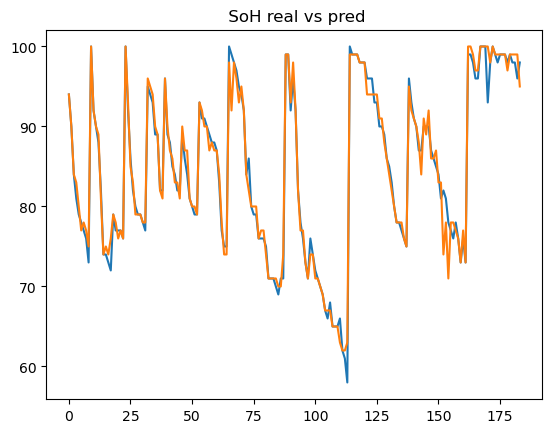

In [30]:
# random interval

padded_clf = PaddingTransformer() * RandomIntervalClassifier(n_intervals=5,random_state=1)
#padded_clf = PaddingTransformer() * KNeighborsTimeSeriesClassifier()
padded_clf.fit(x_train, y_train)
y_pred = padded_clf.predict(x_test)

print('MAE% = ' + str(mean_absolute_percentage_error(y_test, y_pred)))
print('MAE = ' + str(mean_absolute_error(y_test, y_pred)))
print('RMSE = ' + str(np.sqrt(np.square(np.subtract(y_test,y_pred)).mean())))


plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()

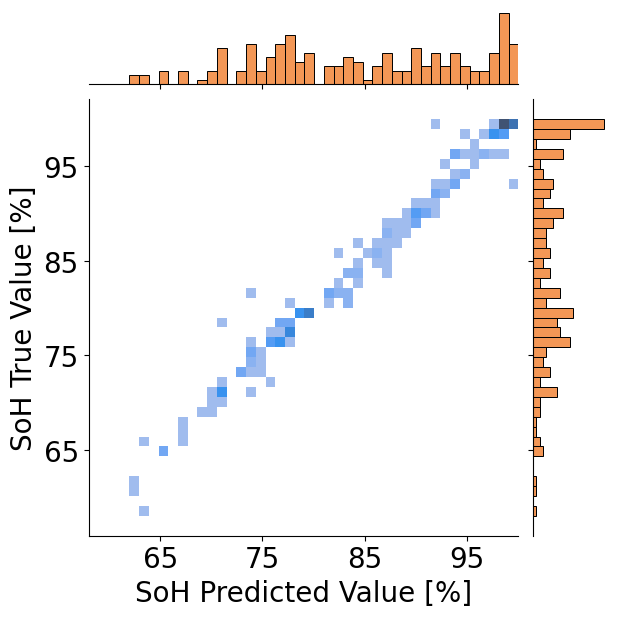

In [9]:
# plotto risultati

import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt


real_pred = {
    'real':y_test.values,
    'pred':y_pred
}
df_plot = pd.DataFrame(real_pred)

colors = ["#F0741E", "#276CB3"]

class_names = np.union1d(np.unique(df_plot['real']), (np.unique(df_plot['pred'])))


g = sns.jointplot(x="pred", 
                  y="real", 
                  data=df_plot, 
                  kind="hist", 
                  marginal_kws={"color": colors[0], "bins":len(class_names)},
                  joint_kws={"color": colors[1], "bins": len(class_names)} 
                  )


g.ax_joint.tick_params(axis="both", which="major", labelsize=20)
ticks = np.arange(65, 101, 10)
labels = [f'{x}' for x in ticks]
g.ax_joint.set_xlim([min(class_names),max(class_names)])
#g.ax_joint.xaxis.set_major_locator(MaxNLocator(nbins=3))  # Auto tick locator
#g.ax_joint.yaxis.set_major_locator(MaxNLocator(nbins=3))  #
g.ax_joint.set_yticks(ticks,labels=labels)
g.ax_joint.set_xticks(ticks,labels=labels)

g.set_axis_labels(
    'SoH Predicted Value [%]', 'SoH True Value [%]' ,fontsize=20
)

plt.savefig('plot/100_nasa_oxford.png', dpi=300, bbox_inches="tight")

In [ ]:
from sklearn.metrics import classification_report

# Calcolo degli indici di valutazione
target_names = [f'{l}' for l in class_names]

report = classification_report(df['real'], df['pred'], target_names=target_names )

print("Matrice di Confusione:")
print(cm)
print("\nReport di Classificazione:")
print(report)

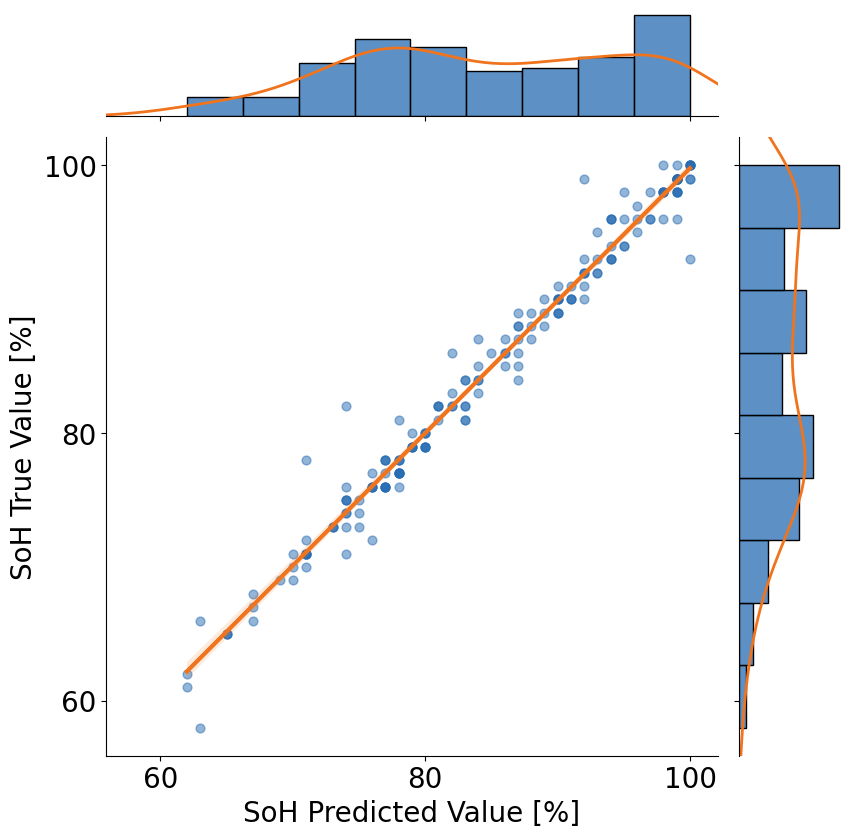

In [26]:


real_pred = {
    'real':y_test.values,
    'pred':y_pred
}
df_plot = pd.DataFrame(real_pred)


colors = ["#F0741E", "#276CB3"]
g = sns.JointGrid(height=8)
#fig = plt.figure(figsize=(8,8))
x, y = df_plot['pred'], df_plot['real']


MAX = np.max(
        [df["real"].to_numpy(), df["pred"].to_numpy()]
    )
MIN = np.min(
        [df["real"].to_numpy(), df["pred"].to_numpy()]
    )

offset = 0.05 * np.abs(MAX - MIN)
bound = [MIN - offset, MAX + offset]


sns.regplot(
    x=x,
    y=y,
    data=df,
    ax=g.ax_joint,
    scatter_kws={"s": 40, "alpha": 0.5, "color": colors[1]},
    line_kws={"linewidth": 3, "alpha": 1, "color": colors[0]},
)
sns.histplot(
    x=x,
    fill=True,
    linewidth=1,
    kde=False,
    ax=g.ax_marg_x,
    stat="density",
    color=colors[1],
)
sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x, color=colors[0])
sns.histplot(
    y=y,
    fill=True,
    linewidth=1,
    kde=False,
    ax=g.ax_marg_y,
    stat="density",
    color=colors[1],
)
sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y, color=colors[0])
# g.ax_joint.set_xticks(ticks)
# g.ax_joint.set_yticks(ticks)
g.ax_joint.set_xlim(bound)
g.ax_joint.set_ylim(bound)
g.ax_joint.tick_params(axis="both", which="major", labelsize=20)
g.ax_joint.xaxis.set_major_locator(MaxNLocator(nbins=3))  # Auto tick locator
g.ax_joint.yaxis.set_major_locator(MaxNLocator(nbins=3))  #
g.set_axis_labels(
    'SoH Predicted Value [%]', 'SoH True Value [%]' ,fontsize=20
)

plt.savefig('plot/prova.png', dpi=300, bbox_inches="tight")







In [57]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

cm = multilabel_confusion_matrix(df['real'], df['pred'], labels=padded_clf.classes_)

# Creazione di un DataFrame per la matrice di confusione
cm_df = pd.DataFrame(cm, index=padded_clf.classes_, columns=padded_clf.classes_)



# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
ConfusionMatrixDisplay.from_estimator(
    df['real'], df['pred'], y_test)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

ValueError: Must pass 2-d input. shape=(44, 2, 2)

In [11]:
#KNeighborsTimeSeriesClassifier

padded_clf = PaddingTransformer() * KNeighborsTimeSeriesClassifier(n_neighbors=5, n_jobs=10)
padded_clf.fit(x_train, y_train)

y_pred = padded_clf.predict(x_test)

print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()

KeyboardInterrupt: 

In [59]:

clf =  RocketClassifier()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()

KeyboardInterrupt: 

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0.03632862729122225
3.1292134831460676


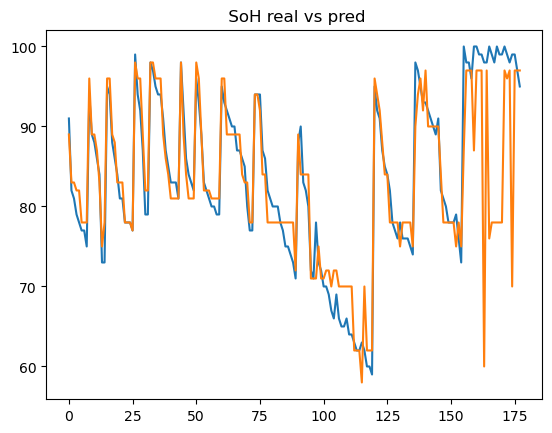

In [23]:
lstm = LSTMFCNClassifier(n_epochs=500,batch_size=16) 
lstm.fit(x_train, y_train)

y_pred = lstm.predict(x_test)

print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()

/home/apetrella/miniconda3/envs/battery_tsc/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
0.17571031779794205
14.764044943820224


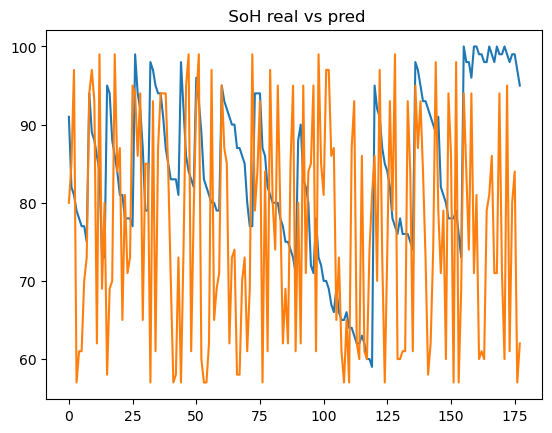

In [24]:
rnn = SimpleRNNClassifier(n_epochs=500,batch_size=16) 
rnn.fit(x_train, y_train)

y_pred = rnn.predict(x_test)

print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
0.12228969119840441
9.432584269662922


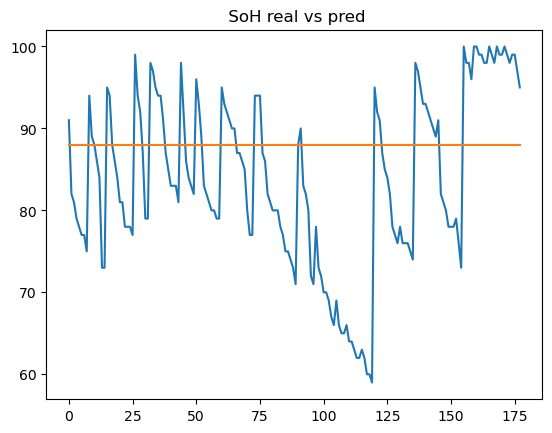

In [25]:
cnn = CNNClassifier(n_epochs=500,batch_size=16) 
cnn.fit(x_train, y_train)

y_pred = cnn.predict(x_test)

print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()